In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from numba import njit

In [ ]:
@njit
def explicit_scheme_2d(f, h, tau, T, a, q):

    t_list = [0]
    val_list = [f.copy()]

    t = 0
    t1 = 0

    while t < T:
        t += tau
        t1 += tau

        f_plus_1 = f.copy()

        f_plus_1[1:-1, 1:-1] = f[1:-1, 1:-1] \
            + tau / (h * h) * a * (f[2:, 1:-1] + f[0:-2, 1:-1]
                                   + f[1:-1, 2:] + f[1:-1, 0:-2]
                                   - 4 * f[1:-1, 1:-1])

        # f_plus_1[:, 0] = f_plus_1[:, 1] + q * h
        # f_plus_1[-1, :] = f_plus_1[-2, :] + q * h
        # f_plus_1[:, -1] = f_plus_1[:, -2] + q * h
        # f_plus_1[0, :] = f_plus_1[1, :] + q * h

        f = f_plus_1.copy()

        f[:, 0] = (4 * f_plus_1[:, 1] - f_plus_1[:, 2] + 2 * q * h) / 3
        f[-1, :] = (4 * f_plus_1[-2, :] - f_plus_1[-3, :] + 2 * q * h) / 3
        # f[:, -1] = (4 * f_plus_1[:, -2] - f_plus_1[:, -3] + 2 * q * h) / 3
        f[0, :] = (4 * f_plus_1[1, :] - f_plus_1[2, :] + 2 * q * h) / 3

        if t1 >= h:
            t_list.append(t)
            val_list.append(f.copy())
            t1 -= h

    return t_list, val_list

In [3]:
X_MAX = 1
T_MAX = 1
N = 201
q = 10

x = y = np.linspace(0, X_MAX, N)
X, Y = np.meshgrid(x, y)

f_0 = np.zeros_like(X)


h = X_MAX / N
tau = h * h / 4 / 0.5

t, u1 = explicit_scheme_2d(f_0, h, tau, T_MAX, 0.1, q)
t, u2 = explicit_scheme_2d(f_0, h, tau, T_MAX, 0.5, q)

u1, u2 = np.array(u1), np.array(u2)

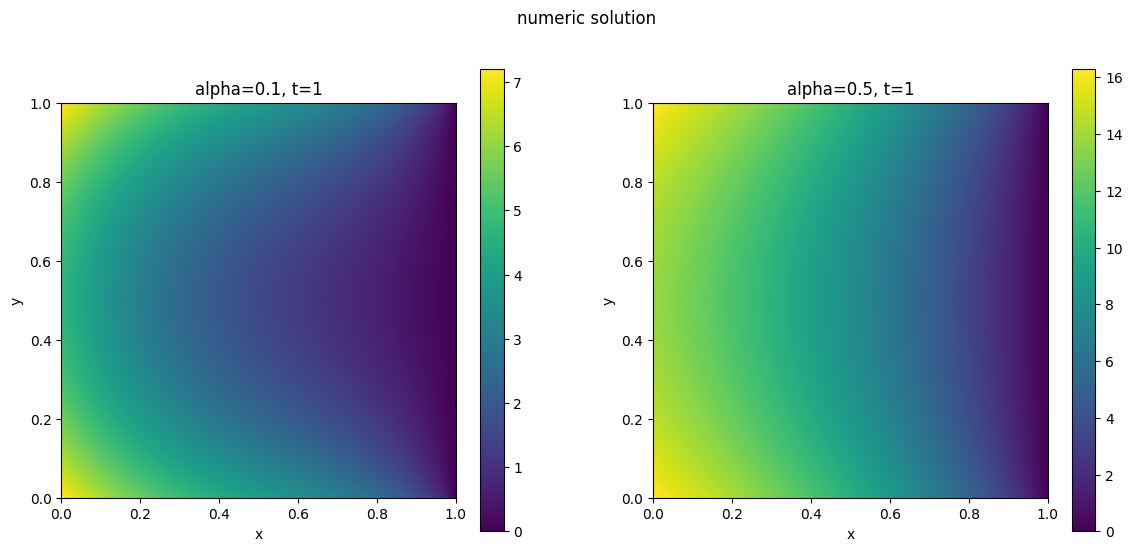

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

for i, (alpha, ui) in enumerate([(0.1, u1), (0.5, u2)]):
    im1 = ax[i].imshow(ui[-1], origin='lower', extent=[0, 1, 0, 1])
    fig.colorbar(im1, ax=ax[i])
    ax[i].set_xlabel('x')
    ax[i].set_ylabel('y')
    ax[i].set_title(f'alpha={alpha}, t=1')

plt.suptitle('numeric solution')
plt.show()

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
def pde_loss(model, points, coll_weights):
    x, y, t, a = points[:, :1], points[:, 1:2], points[:, 2:3], points[:, 3:4]

    x.requires_grad_(True)
    y.requires_grad_(True)
    t.requires_grad_(True)
    a.requires_grad_(True)

    inputs = torch.cat([x, y, t, a], dim=1)
    u = model(inputs)

    u_t = torch.autograd.grad(
        u, t,
        grad_outputs=torch.ones_like(u),
        create_graph=True
    )[0]

    u_x = torch.autograd.grad(
        u, x,
        grad_outputs=torch.ones_like(u),
        create_graph=True
    )[0]

    u_xx = torch.autograd.grad(
        u_x, x,
        grad_outputs=torch.ones_like(u_x),
        create_graph=True
    )[0]

    u_y = torch.autograd.grad(
        u, y,
        grad_outputs=torch.ones_like(u),
        create_graph=True
    )[0]

    u_yy = torch.autograd.grad(
        u_y, y,
        grad_outputs=torch.ones_like(u_y),
        create_graph=True
    )[0]

    residual = u_t - a * (u_xx + u_yy)

    loss = torch.mean((residual * coll_weights) ** 2)

    return loss


def LB_loss(model, points, q, left_bound_weights):
    x, y, t, a = points[:, :1], points[:, 1:2], points[:, 2:3], points[:, 3:4]

    x.requires_grad_(True)
    y.requires_grad_(True)
    t.requires_grad_(True)
    a.requires_grad_(True)

    inputs = torch.cat([x, y, t, a], dim=1)
    u = model(inputs)

    u_x = torch.autograd.grad(
        u, x,
        grad_outputs=torch.ones_like(u),
        create_graph=True
    )[0]

    residual = u_x + q

    loss = torch.mean((residual * left_bound_weights) ** 2)

    return loss


def TB_loss(model, points, q, top_bound_weights):
    x, y, t, a = points[:, :1], points[:, 1:2], points[:, 2:3], points[:, 3:4]

    x.requires_grad_(True)
    y.requires_grad_(True)
    t.requires_grad_(True)
    a.requires_grad_(True)

    inputs = torch.cat([x, y, t, a], dim=1)
    u = model(inputs)

    u_y = torch.autograd.grad(
        u, y,
        grad_outputs=torch.ones_like(u),
        create_graph=True
    )[0]

    residual = u_y - q

    loss = torch.mean((residual * top_bound_weights) ** 2)

    return loss


def RB_loss(model, points, right_bound_weights):
    x, y, t, a = points[:, :1], points[:, 1:2], points[:, 2:3], points[:, 3:4]

    x.requires_grad_(True)
    y.requires_grad_(True)
    t.requires_grad_(True)
    a.requires_grad_(True)

    inputs = torch.cat([x, y, t, a], dim=1)
    u = model(inputs)

    residual = u

    loss = torch.mean((residual * right_bound_weights) ** 2)

    return loss


def RB_dt_loss(model, points, right_bound_weights):
    x, y, t, a = points[:, :1], points[:, 1:2], points[:, 2:3], points[:, 3:4]

    x.requires_grad_(True)
    y.requires_grad_(True)
    t.requires_grad_(True)
    a.requires_grad_(True)

    inputs = torch.cat([x, y, t, a], dim=1)
    u = model(inputs)

    u_t = torch.autograd.grad(
        u, t,
        grad_outputs=torch.ones_like(u),
        create_graph=True
    )[0]

    residual = u_t

    loss = torch.mean((residual * right_bound_weights) ** 2)

    return loss


def BB_loss(model, points, q, bottom_bound_weights):
    x, y, t, a = points[:, :1], points[:, 1:2], points[:, 2:3], points[:, 3:4]

    x.requires_grad_(True)
    y.requires_grad_(True)
    t.requires_grad_(True)
    a.requires_grad_(True)

    inputs = torch.cat([x, y, t, a], dim=1)
    u = model(inputs)

    u_y = torch.autograd.grad(
        u, y,
        grad_outputs=torch.ones_like(u),
        create_graph=True
    )[0]

    residual = u_y + q

    loss = torch.mean((residual * bottom_bound_weights) ** 2)

    return loss


def IC_loss(model, points, init_weights):
    x, y, t, a = points[:, :1], points[:, 1:2], points[:, 2:3], points[:, 3:4]

    x.requires_grad_(True)
    y.requires_grad_(True)
    t.requires_grad_(True)
    a.requires_grad_(True)

    inputs = torch.cat([x, y, t, a], dim=1)
    u = model(inputs)

    residual = u

    loss = torch.mean((residual * init_weights) ** 2)

    return loss


def IC_dx_loss(model, points, init_weights):
    x, y, t, a = points[:, :1], points[:, 1:2], points[:, 2:3], points[:, 3:4]

    x.requires_grad_(True)
    y.requires_grad_(True)
    t.requires_grad_(True)
    a.requires_grad_(True)

    inputs = torch.cat([x, y, t, a], dim=1)
    u = model(inputs)

    u_x = torch.autograd.grad(
        u, x,
        grad_outputs=torch.ones_like(u),
        create_graph=True
    )[0]

    residual = u_x

    loss = torch.mean((residual * init_weights) ** 2)

    return loss


def IC_dy_loss(model, points, init_weights):
    x, y, t, a = points[:, :1], points[:, 1:2], points[:, 2:3], points[:, 3:4]

    x.requires_grad_(True)
    y.requires_grad_(True)
    t.requires_grad_(True)
    a.requires_grad_(True)

    inputs = torch.cat([x, y, t, a], dim=1)
    u = model(inputs)

    u_y = torch.autograd.grad(
        u, y,
        grad_outputs=torch.ones_like(u),
        create_graph=True
    )[0]

    residual = u_y

    loss = torch.mean((residual * init_weights) ** 2)

    return loss

In [8]:
def weights(n):
    return nn.Parameter(torch.full((n, 1), 1.0).to(device))


class PINN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)


class AdaptivePINN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(AdaptivePINN, self).__init__()
        self.pinn = PINN(input_dim, hidden_dim, output_dim)

        self.coll_weights = weights(10000)
        self.left_bound_weights = weights(1000)
        self.top_bound_weights = weights(1000)
        self.right_bound_weights = weights(1000)
        self.bottom_bound_weights = weights(1000)
        self.init_weights = weights(1000)

        self.data_weights = weights(10000)

    def forward(self, x):
        return self.pinn(x)

    def loss(self, coll_data, lb_data, tb_data, rb_data, bb_data, 
             init_data, q, data_data=None):
        coll_loss = pde_loss(self, coll_data, self.coll_weights)

        lb_loss = LB_loss(self, lb_data, q, self.left_bound_weights)
        tb_loss = TB_loss(self, tb_data, q, self.top_bound_weights)
        rb_loss = RB_loss(self, rb_data, self.right_bound_weights)
        bb_loss = BB_loss(self, bb_data, q, self.right_bound_weights)

        init_loss = IC_loss(self, init_data, self.init_weights)
        init_dx_loss = IC_dx_loss(self, init_data, self.init_weights)
        init_dy_loss = IC_dy_loss(self, init_data, self.init_weights)

        rb_dt_loss = RB_dt_loss(self, rb_data, self.right_bound_weights)

        total_loss = coll_loss + \
            lb_loss + tb_loss + rb_loss + bb_loss + \
                init_loss + init_dx_loss + init_dy_loss + rb_dt_loss

        if data_data is not None:
            x, y, t, a, y_true = data_data[:, :1], data_data[:, 1:2], \
                data_data[:, 2:3], data_data[:, 3:4], data_data[:, 4:5]
            x.requires_grad_(True)
            y.requires_grad_(True)
            t.requires_grad_(True)
            a.requires_grad_(True)

            inputs = torch.cat([x, y, t, a], dim=1)
            u = self(inputs)

            residual = u - y_true

            total_loss += torch.mean((residual * self.data_weights) ** 2)

        return total_loss

In [ ]:
num_points = 1000
coll_t = torch.rand(num_points * 10, 1).to(device)
coll_x = torch.rand_like(coll_t).to(device)
coll_y = torch.rand_like(coll_t).to(device)
coll_a = (torch.randint_like(coll_t, 0, 2).to(device) * 4 + 1) / 10

init_t = torch.zeros(num_points, 1).to(device)
init_x = torch.rand_like(init_t).to(device)
init_y = torch.rand_like(init_t).to(device)
init_a = (torch.randint_like(init_t, 0, 2).to(device) * 4 + 1) / 10

left_bound_t = torch.rand(num_points, 1).to(device)
left_bound_x = torch.full_like(left_bound_t, 0).to(device)
left_bound_y = torch.rand_like(left_bound_t).to(device)
left_bound_a = (torch.randint_like(left_bound_t, 0, 2).to(device) * 4 + 1) / 10

top_bound_t = torch.rand(num_points, 1).to(device)
top_bound_x = torch.rand_like(top_bound_t).to(device)
top_bound_y = torch.full_like(top_bound_t, X_MAX).to(device)
top_bound_a = (torch.randint_like(top_bound_t, 0, 2).to(device) * 4 + 1) / 10

right_bound_t = torch.rand(num_points, 1).to(device)
right_bound_x = torch.full_like(right_bound_t, X_MAX).to(device)
right_bound_y = torch.rand_like(right_bound_t).to(device)
right_bound_a = (
    torch.randint_like(right_bound_t, 0, 2).to(device) * 4 + 1) / 10

bottom_bound_t = torch.rand(num_points, 1).to(device)
bottom_bound_x = torch.rand_like(bottom_bound_t).to(device)
bottom_bound_y = torch.full_like(bottom_bound_t, 0).to(device)
bottom_bound_a = (
    torch.randint_like(bottom_bound_t, 0, 2).to(device) * 4 + 1) / 10

In [ ]:
input_dim = 4
hidden_dim = 100
output_dim = 1
q = 10

model = AdaptivePINN(input_dim, hidden_dim, output_dim)
model = model.to(device)

optimizer = torch.optim.Adam(
    [param for name, param in
     model.named_parameters() if "weights" not in name],
    lr=0.0005,
)
weights_optimizer = torch.optim.Adam(
    [param for name, param in model.named_parameters() if "weights" in name],
    lr=0.0001,
)

coll_weights_history = []

epochs = 20000
model.train()
for epoch in range(epochs):
    optimizer.zero_grad()
    weights_optimizer.zero_grad()

    loss = model.loss(
        torch.cat(
            [
                coll_x,
                coll_y,
                coll_t,
                coll_a,
            ],
            dim=1,
        ),
        torch.cat(
            [
                left_bound_x,
                left_bound_y,
                left_bound_t,
                left_bound_a,
            ],
            dim=1,
        ),
        torch.cat(
            [
                top_bound_x,
                top_bound_y,
                top_bound_t,
                top_bound_a,
            ],
            dim=1,
        ),
        torch.cat(
            [
                right_bound_x,
                right_bound_y,
                right_bound_t,
                right_bound_a,
            ],
            dim=1,
        ),
        torch.cat(
            [
                bottom_bound_x,
                bottom_bound_y,
                bottom_bound_t,
                bottom_bound_a,
            ],
            dim=1,
        ),
        torch.cat(
            [
                init_x,
                init_y,
                init_t,
                init_a,
            ],
            dim=1,
        ),
        q,
    )

    loss.backward()
    optimizer.step()
    weights_optimizer.step()

    if epoch % 100 == 0:
        with torch.autograd.no_grad():
            print(f"Epoch {epoch}, Loss: {loss.item()}")
    if epoch % 3333 == 0:
        with torch.autograd.no_grad():
            coll_weights_history.append(model.coll_weights.clone())

d:\ML\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 0, Loss: 299.92236328125
Epoch 100, Loss: 91.25720977783203
Epoch 200, Loss: 33.63622283935547
Epoch 300, Loss: 20.288040161132812
Epoch 400, Loss: 12.982812881469727
Epoch 500, Loss: 10.191455841064453
Epoch 600, Loss: 8.826580047607422
Epoch 700, Loss: 11.482809066772461
Epoch 800, Loss: 6.8778605461120605
Epoch 900, Loss: 6.316741943359375
Epoch 1000, Loss: 5.890067100524902
Epoch 1100, Loss: 5.389160633087158
Epoch 1200, Loss: 4.995166301727295
Epoch 1300, Loss: 4.9925923347473145
Epoch 1400, Loss: 4.664552211761475
Epoch 1500, Loss: 4.104108810424805
Epoch 1600, Loss: 3.6828272342681885
Epoch 1700, Loss: 3.993889331817627
Epoch 1800, Loss: 3.0526697635650635
Epoch 1900, Loss: 2.8081624507904053
Epoch 2000, Loss: 2.7142763137817383
Epoch 2100, Loss: 2.820937156677246
Epoch 2200, Loss: 2.204658031463623
Epoch 2300, Loss: 2.0494863986968994
Epoch 2400, Loss: 1.7746665477752686
Epoch 2500, Loss: 1.6708701848983765
Epoch 2600, Loss: 1.7492859363555908
Epoch 2700, Loss: 1.51882576

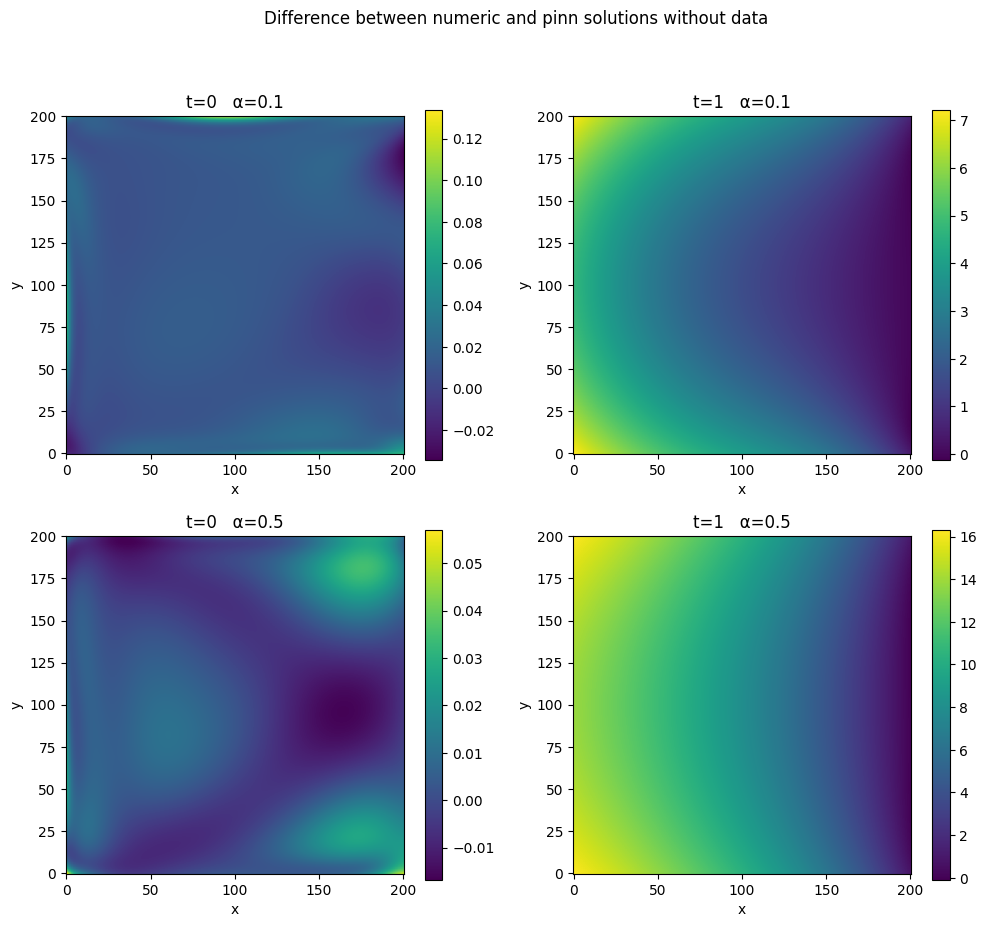

In [29]:
model.eval()

fig, ax = plt.subplots(2, 2, figsize=(12, 10))

for i, (alpha, ui) in enumerate([(0.1, u1), (0.5, u2)]):
    for j, time in enumerate([0, 1]):
        x = torch.from_numpy(X).float().reshape(-1, 1).to(device)
        y = torch.from_numpy(Y).float().reshape(-1, 1).to(device)
        t = torch.full_like(x, time).to(device)
        a = torch.full_like(x, alpha).to(device)

        inputs = torch.cat([x, y, t, a], dim=1)
        res = model(inputs).reshape(X.shape)

        im1 = ax[i][j].imshow(res.cpu().detach().numpy(), origin='lower')
        fig.colorbar(im1, ax=ax[i][j])
        ax[i][j].set_xlabel('x')
        ax[i][j].set_ylabel('y')
        ax[i][j].set_title(f't={time}   α={alpha}')

plt.suptitle('Difference between numeric and pinn solutions without data')
plt.show()

In [26]:
import plotly.express as px

fig = px.scatter_3d(
    x=coll_x.cpu().reshape(-1),
    y=coll_y.cpu().reshape(-1),
    z=coll_t.cpu().reshape(-1),
    color=model.coll_weights.cpu().detach().numpy().reshape(-1),
    size=torch.full_like(coll_x, 1).reshape(-1).cpu(),
    title='Collocation weights for pinn without data',
    labels={"x": "x", "y": "y", 'z':'t'}
)
# fig.show()
fig.write_html('no_data.html')

In [ ]:
x = torch.tensor(np.linspace(0, X_MAX, N)).to(device)
y = torch.tensor(np.linspace(0, X_MAX, N)).to(device)
t = torch.tensor(np.linspace(0, T_MAX, N)).to(device)
u = torch.tensor(np.array([u1, u2])).to(device)

data_t_idx = torch.randint(0, len(t), (num_points * 10,)).to(device)
data_x_idx = torch.randint_like(data_t_idx, 0, len(x)).to(device)
data_y_idx = torch.randint_like(data_t_idx, 0, len(y)).to(device)
data_a_idx = torch.randint_like(data_t_idx, 0, 2).to(device)

data_t = t[data_t_idx].reshape(-1, 1).float()
data_y = y[data_y_idx].reshape(-1, 1).float()
data_x = x[data_x_idx].reshape(-1, 1).float()
data_a = ((data_a_idx * 4 + 1) / 10).reshape(-1, 1)
data_u = u[data_a_idx, data_t_idx, data_y_idx,
           data_x_idx].reshape(-1, 1).float()

In [ ]:
input_dim = 4
hidden_dim = 100
output_dim = 1
q = 10

model_with_data = AdaptivePINN(input_dim, hidden_dim, output_dim)
model_with_data = model_with_data.to(device)

optimizer2 = torch.optim.Adam(
    [param for name, param in
     model_with_data.named_parameters() if "weights" not in name],
    lr=0.0005
)
weights_optimizer2 = torch.optim.Adam(
    [param for name, param in
     model_with_data.named_parameters() if "weights" in name],
    lr=0.0001
)

coll_weights_history2 = []

epochs = 20000
for epoch in range(epochs):
    optimizer2.zero_grad()
    weights_optimizer2.zero_grad()

    loss = model_with_data.loss(
        torch.cat(
            [
                coll_x,
                coll_y,
                coll_t,
                coll_a,
            ],
            dim=1,
        ),
        torch.cat(
            [
                left_bound_x,
                left_bound_y,
                left_bound_t,
                left_bound_a,
            ],
            dim=1,
        ),
        torch.cat(
            [
                top_bound_x,
                top_bound_y,
                top_bound_t,
                top_bound_a,
            ],
            dim=1,
        ),
        torch.cat(
            [
                right_bound_x,
                right_bound_y,
                right_bound_t,
                right_bound_a,
            ],
            dim=1,
        ),
        torch.cat(
            [
                bottom_bound_x,
                bottom_bound_y,
                bottom_bound_t,
                bottom_bound_a,
            ],
            dim=1,
        ),
        torch.cat(
            [
                init_x,
                init_y,
                init_t,
                init_a,
            ],
            dim=1,
        ),
        q,
        torch.cat(
            [
                data_x,
                data_y,
                data_t,
                data_a,
                data_u,
            ],
            dim=1,
        ),
    )

    loss.backward()
    optimizer2.step()
    weights_optimizer2.step()

    if epoch % 100 == 0:
        with torch.autograd.no_grad():
            print(f"Epoch {epoch}, Loss: {loss.item()}")

    if epoch % 3333 == 0:
        with torch.autograd.no_grad():
            coll_weights_history2.append(
                model_with_data.coll_weights.clone())

Epoch 0, Loss: 320.8677978515625
Epoch 100, Loss: 81.6754150390625
Epoch 200, Loss: 39.13501739501953
Epoch 300, Loss: 22.1304988861084
Epoch 400, Loss: 14.813684463500977
Epoch 500, Loss: 12.41426944732666
Epoch 600, Loss: 9.547130584716797
Epoch 700, Loss: 7.935817718505859
Epoch 800, Loss: 7.608347415924072
Epoch 900, Loss: 6.503009796142578
Epoch 1000, Loss: 5.8092427253723145
Epoch 1100, Loss: 5.843958377838135
Epoch 1200, Loss: 5.243774890899658
Epoch 1300, Loss: 4.924460411071777
Epoch 1400, Loss: 4.139720916748047
Epoch 1500, Loss: 3.3982322216033936
Epoch 1600, Loss: 3.327516794204712
Epoch 1700, Loss: 2.953701972961426
Epoch 1800, Loss: 2.5577392578125
Epoch 1900, Loss: 2.9254448413848877
Epoch 2000, Loss: 2.37420916557312
Epoch 2100, Loss: 1.9529688358306885
Epoch 2200, Loss: 1.9401847124099731
Epoch 2300, Loss: 1.5605262517929077
Epoch 2400, Loss: 1.7757737636566162
Epoch 2500, Loss: 1.6680773496627808
Epoch 2600, Loss: 1.2994015216827393
Epoch 2700, Loss: 1.258381962776184

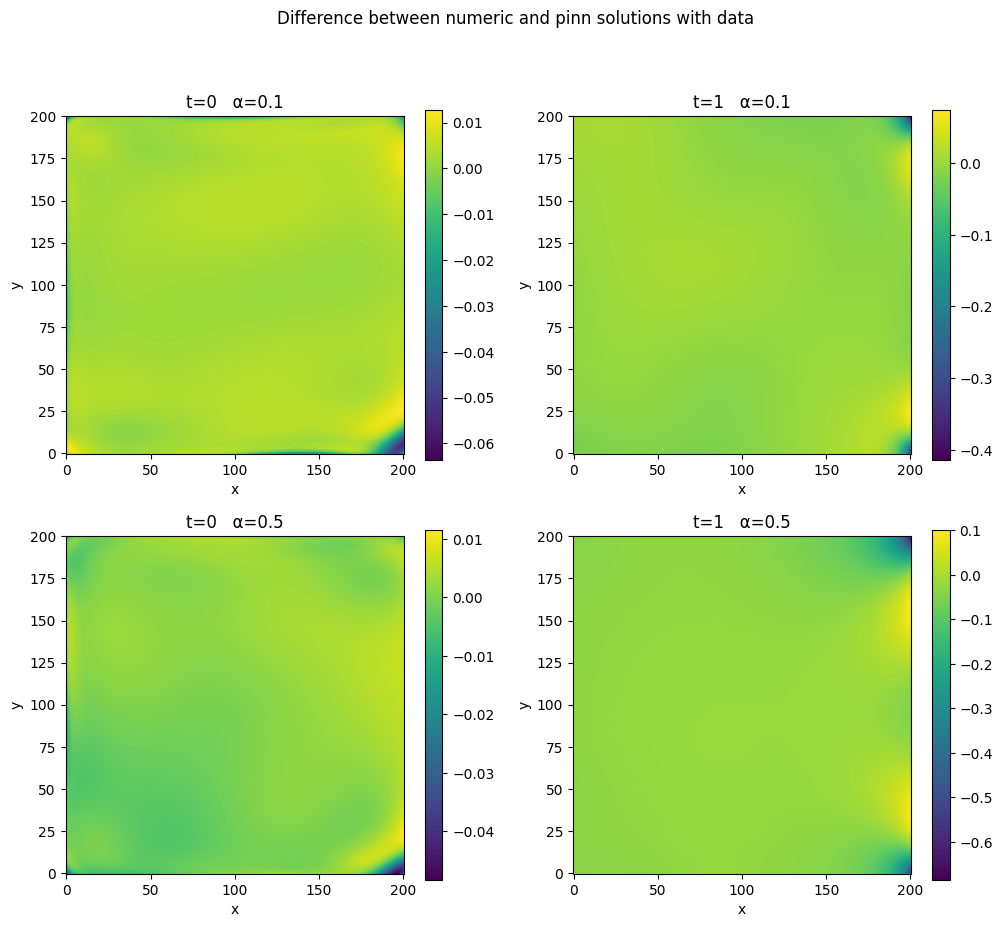

In [ ]:
model_with_data.eval()

fig, ax = plt.subplots(2, 2, figsize=(12, 10))

for i, (alpha, ui) in enumerate([(0.1, u1), (0.5, u2)]):
    for j, time in enumerate([0, 1]):
        x = torch.from_numpy(X).float().reshape(-1, 1).to(device)
        y = torch.from_numpy(Y).float().reshape(-1, 1).to(device)
        t = torch.full_like(x, time).to(device)
        a = torch.full_like(x, alpha).to(device)

        inputs = torch.cat([x, y, t, a], dim=1)
        res = model_with_data(inputs).reshape(X.shape)

        im1 = ax[i][j].imshow(
            ui[time * 200] - res.cpu().detach().numpy(), origin='lower')
        fig.colorbar(im1, ax=ax[i][j])
        ax[i][j].set_xlabel('x')
        ax[i][j].set_ylabel('y')
        ax[i][j].set_title(f't={time}   α={alpha}')

plt.suptitle('Difference between numeric and pinn solutions with data')
plt.show()

In [ ]:
torch.save([
    torch.cat([
        coll_x,
        coll_y,
        coll_t,
        coll_a,
    ], dim=1),
    torch.cat([
        left_bound_x,
        left_bound_y,
        left_bound_t,
        left_bound_a,
    ], dim=1),
    torch.cat([
        top_bound_x,
        top_bound_y,
        top_bound_t,
        top_bound_a,
    ], dim=1),
    torch.cat([
        right_bound_x,
        right_bound_y,
        right_bound_t,
        right_bound_a,
    ], dim=1),
    torch.cat([
        bottom_bound_x,
        bottom_bound_y,
        bottom_bound_t,
        bottom_bound_a,
    ], dim=1),
    torch.cat([
        init_x,
        init_y,
        init_t,
        init_a,
    ], dim=1),
    q,
    torch.cat([
        data_x,
        data_y,
        data_t,
        data_a,
        data_u,
    ], dim=1),
], 'asymetric.file')

In [31]:
torch.save(model.state_dict(), 'asym_no_data.pt')
torch.save(model_with_data.state_dict(), 'asym_with_data.pt')

In [ ]:
import plotly.express as px

fig = px.scatter_3d(
    x=coll_x.cpu().reshape(-1),
    y=coll_y.cpu().reshape(-1),
    z=coll_t.cpu().reshape(-1),
    color=model_with_data.coll_weights.cpu().detach().numpy().reshape(-1),
    size=torch.full_like(coll_x, 1).reshape(-1).cpu(),
    title='Collocation weights for pinn with data',
    labels={"x": "x", "y": "y", 'z':'t'}
)
# fig.show()
fig.write_html('with_data.html')

In [9]:
from matplotlib import animation

In [ ]:
smth = torch.load('asymetric.file')

coll_x, coll_y, coll_t, coll_a = smth[0][:, 0:1], smth[0][:, 1:2], \
    smth[0][:, 2:3], smth[0][:, 3:4]
left_bound_x, left_bound_y, left_bound_t, left_bound_a = smth[1][:, 0:1], \
    smth[1][:, 1:2], smth[1][:, 2:3], smth[1][:, 3:4]
top_bound_x, top_bound_y, top_bound_t, top_bound_a = smth[2][:, 0:1], \
    smth[2][:, 1:2], smth[2][:, 2:3], smth[2][:, 3:4]
right_bound_x, right_bound_y, right_bound_t, right_bound_a = \
    smth[3][:, 0:1], smth[3][:, 1:2], smth[3][:, 2:3], smth[3][:, 3:4]
bottom_bound_x, bottom_bound_y, bottom_bound_t, bottom_bound_a = \
    smth[4][:, 0:1], smth[4][:, 1:2], smth[4][:, 2:3], smth[4][:, 3:4]
init_x, init_y, init_t, init_a = smth[5][:, 0:1], smth[5][:, 1:2], \
    smth[5][:, 2:3], smth[5][:, 3:4]

q = smth[6]

data_x, data_y, data_t, data_a, data_u = smth[7][:, 0:1], smth[7][:, 1:2], \
    smth[7][:, 2:3], smth[7][:, 3:4], smth[7][:, 4:5]

In [11]:
input_dim = 4
hidden_dim = 100
output_dim = 1

model = AdaptivePINN(input_dim, hidden_dim, output_dim)
model = model.to(device)

model.load_state_dict(torch.load('asym_no_data.pt'))

<All keys matched successfully>

In [12]:
model_with_data = AdaptivePINN(input_dim, hidden_dim, output_dim)
model_with_data = model_with_data.to(device)

model_with_data.load_state_dict(torch.load('asym_with_data.pt'))

<All keys matched successfully>

In [ ]:
model.eval()
model_with_data.eval()

time_intervals = np.arange(0, 1.1, 0.1)
interval_frames = []

for i in range(len(time_intervals) - 1):
    t_start = time_intervals[i]
    t_end = time_intervals[i + 1]

    mask = (coll_t >= t_start) & (coll_t < t_end)
    mask1 = (coll_t >= t_start) & (coll_t < t_end) & (coll_a == 0.1)
    mask2 = (coll_t >= t_start) & (coll_t < t_end) & (coll_a == 0.5)
    interval_data = (
        (
            coll_x[mask].cpu(), coll_y[mask].cpu(),
            model.coll_weights[mask].cpu().detach().numpy(),
        ),
        (
            coll_x[mask1].cpu(), coll_y[mask1].cpu(),
            model.coll_weights[mask1].cpu().detach().numpy(),
        ),
        (
            coll_x[mask2].cpu(), coll_y[mask2].cpu(),
            model.coll_weights[mask2].cpu().detach().numpy(),
        ),
        (
            coll_x[mask].cpu(), coll_y[mask].cpu(),
            model_with_data.coll_weights[mask].cpu().detach().numpy(),
        ),
        (
            coll_x[mask1].cpu(), coll_y[mask1].cpu(),
            model_with_data.coll_weights[mask1].cpu().detach().numpy(),
        ),
        (
            coll_x[mask2].cpu(), coll_y[mask2].cpu(),
            model_with_data.coll_weights[mask2].cpu().detach().numpy(),
        ),
    )
    interval_frames.append(interval_data)

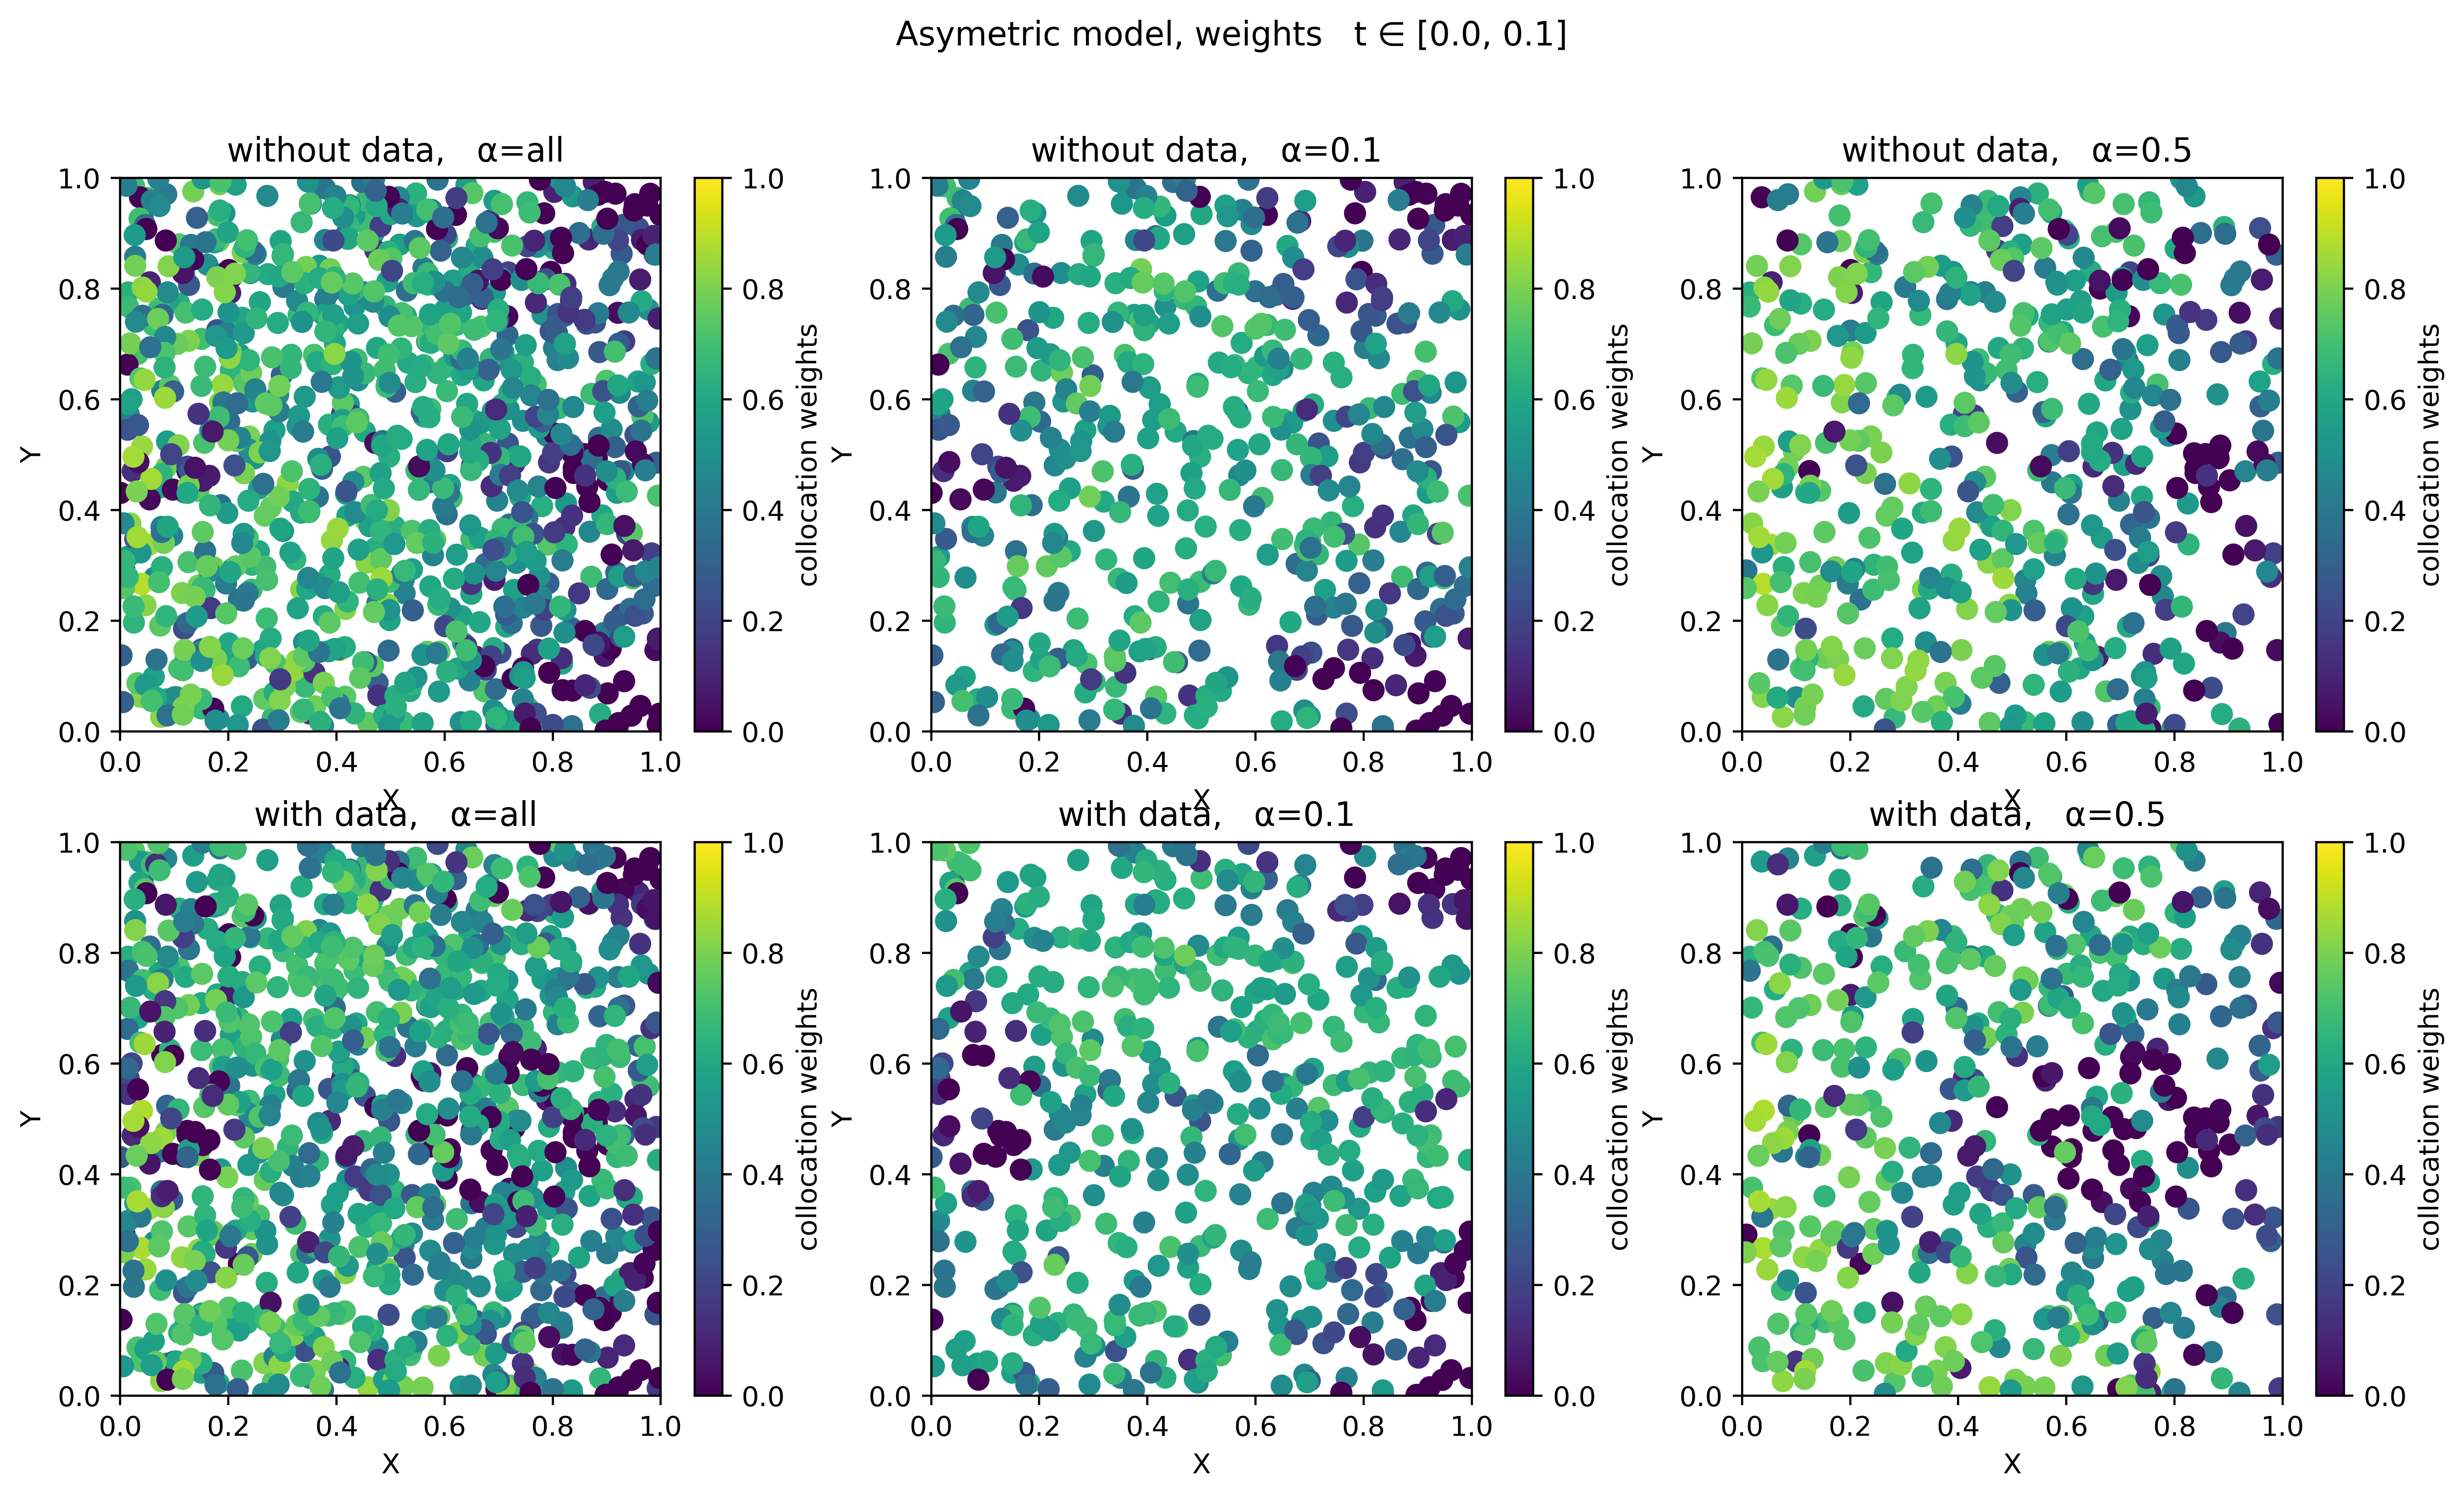

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(15, 8), dpi=400)

sc = []

for i in range(2):
    for j in range(3):
        sc.append(ax[i][j].scatter([], [], c=[], cmap="viridis", s=50))
        cbar = plt.colorbar(sc[-1], ax=ax[i][j])
        cbar.set_label("collocation weights")
        ax[i][j].set_xlim(0, 1)
        ax[i][j].set_ylim(0, 1)
        ax[i][j].set_xlabel("X")
        ax[i][j].set_ylabel("Y")


def update(frame):
    for i in range(2):
        for j in range(3):
            interval_data = interval_frames[frame]
            sc[i * 3 + j].set_offsets(
                np.array(interval_data[i * 3 + j][:2]).T)
            sc[i * 3 + j].set_array(interval_data[i * 3 + j][2])
            ax[i][j].set_title(
                f" with{'out' if i == 0 else ''} data,   "
                f"α={'all' if j == 0 else 0.1 if j == 1 else 0.5}"
            )
    plt.suptitle(
        f'Asymetric model, weights   t ∈ '
        f'[{time_intervals[frame]:.1f}, {time_intervals[frame+1]:.1f}]'
    )
    return sc


ani = animation.FuncAnimation(fig, update, frames=len(interval_frames),
                              blit=False, interval=2000)

ani.save("asymetric_weights.gif", writer="pillow")

In [15]:
def pde_loss_no_mean(model, points, coll_weights):
    x, y, t, a = points[:, :1], points[:, 1:2], points[:, 2:3], points[:, 3:4]

    x.requires_grad_(True)
    y.requires_grad_(True)
    t.requires_grad_(True)
    a.requires_grad_(True)

    inputs = torch.cat([x, y, t, a], dim=1)
    u = model(inputs)

    u_t = torch.autograd.grad(
        u, t,
        grad_outputs=torch.ones_like(u),
        create_graph=True
    )[0]

    u_x = torch.autograd.grad(
        u, x,
        grad_outputs=torch.ones_like(u),
        create_graph=True
    )[0]

    u_xx = torch.autograd.grad(
        u_x, x,
        grad_outputs=torch.ones_like(u_x),
        create_graph=True
    )[0]

    u_y = torch.autograd.grad(
        u, y,
        grad_outputs=torch.ones_like(u),
        create_graph=True
    )[0]

    u_yy = torch.autograd.grad(
        u_y, y,
        grad_outputs=torch.ones_like(u_y),
        create_graph=True
    )[0]

    residual = u_t - a * (u_xx + u_yy)

    loss = abs(residual * coll_weights)

    return loss

In [ ]:
model.eval()
model_with_data.eval()

time_intervals = np.arange(0, 1.1, 0.1)
interval_frames_loss = []

res1 = pde_loss_no_mean(
    model,
    torch.cat([
        coll_x,
        coll_y,
        coll_t,
        coll_a,
    ], dim=1),
    model.coll_weights,
)
res2 = pde_loss_no_mean(
    model_with_data,
    torch.cat([
        coll_x,
        coll_y,
        coll_t,
        coll_a,
    ], dim=1),
    model_with_data.coll_weights,
)

for i in range(len(time_intervals) - 1):
    t_start = time_intervals[i]
    t_end = time_intervals[i + 1]

    mask = (coll_t >= t_start) & (coll_t < t_end)
    mask1 = (coll_t >= t_start) & (coll_t < t_end) & (coll_a == 0.1)
    mask2 = (coll_t >= t_start) & (coll_t < t_end) & (coll_a == 0.5)
    interval_data = (
        (
            coll_x[mask].cpu(),
            coll_y[mask].cpu(),
            res1[mask].cpu().detach().numpy(),
        ),
        (
            coll_x[mask1].cpu(),
            coll_y[mask1].cpu(),
            res1[mask1].cpu().detach().numpy(),
        ),
        (
            coll_x[mask2].cpu(),
            coll_y[mask2].cpu(),
            res1[mask2].cpu().detach().numpy(),
        ),
        (
            coll_x[mask].cpu(),
            coll_y[mask].cpu(),
            res2[mask].cpu().detach().numpy(),
        ),
        (
            coll_x[mask1].cpu(),
            coll_y[mask1].cpu(),
            res2[mask1].cpu().detach().numpy(),
        ),
        (
            coll_x[mask2].cpu(),
            coll_y[mask2].cpu(),
            res2[mask2].cpu().detach().numpy(),
        ),
    )
    interval_frames_loss.append(interval_data)

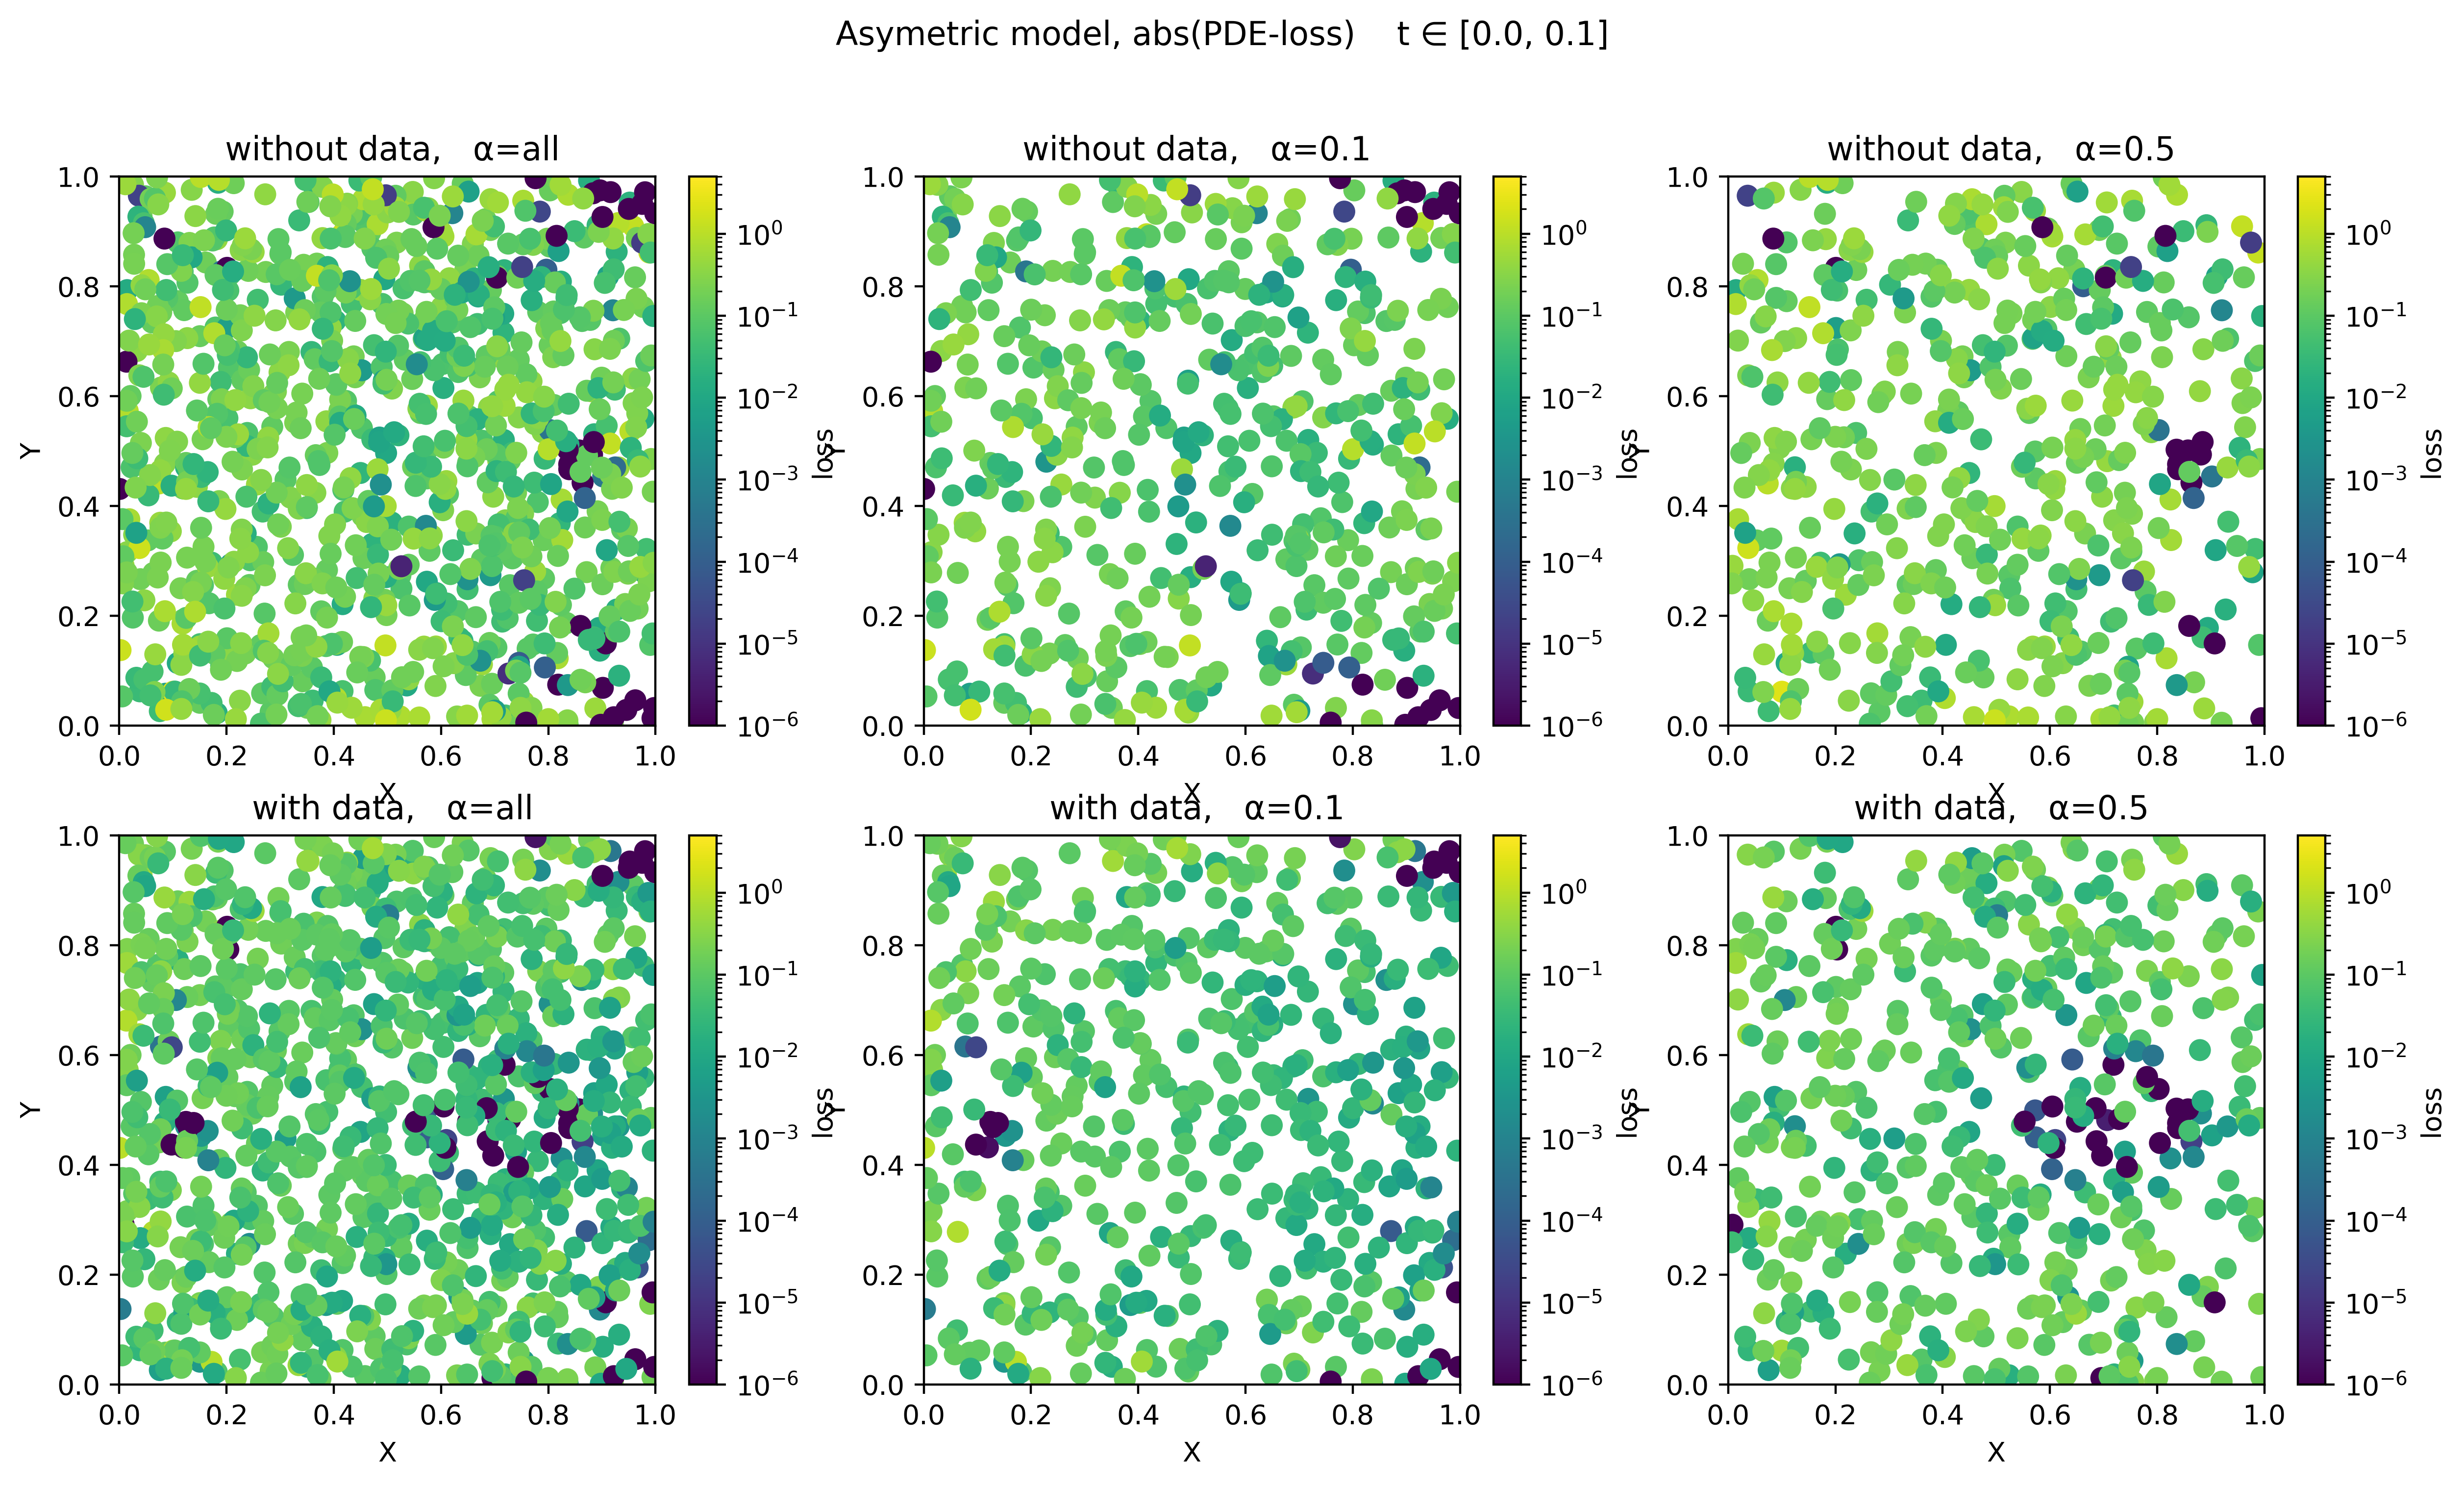

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(15, 8), dpi=400)

sc = []

for i in range(2):
    for j in range(3):
        sc.append(ax[i][j].scatter([], [], c=[], cmap="viridis", s=50,
                                   norm=colors.LogNorm(vmin=1e-6, vmax=5)))
        cbar = plt.colorbar(sc[-1], ax=ax[i][j])
        cbar.set_label("loss")
        ax[i][j].set_xlim(0, 1)
        ax[i][j].set_ylim(0, 1)
        ax[i][j].set_xlabel("X")
        ax[i][j].set_ylabel("Y")


def update(frame):
    for i in range(2):
        for j in range(3):
            interval_data = interval_frames_loss[frame]
            sc[i * 3 + j].set_offsets(np.array(interval_data[i * 3 + j][:2]).T)
            sc[i * 3 + j].set_array(interval_data[i * 3 + j][2])
            ax[i][j].set_title(
                f" with{'out' if i == 0 else ''} data,   "
                f"α={'all' if j == 0 else 0.1 if j == 1 else 0.5}")
    plt.suptitle(
        f'Asymetric model, abs(PDE-loss)    '
        f't ∈ [{time_intervals[frame]:.1f}, {time_intervals[frame+1]:.1f}]')
    return sc


ani = animation.FuncAnimation(fig, update, frames=len(
    interval_frames_loss), blit=False, interval=2000)

ani.save("asymetric_loss.gif", writer="pillow")